# WEMSWOT - ctd/currents

In [ ]:
import os
from glob import glob

import xarray as xr
import pandas as pd
import numpy as np
#from numba import njit, int32, float64

import matplotlib.pyplot as plt
#import seaborn as sns
import hvplot.pandas
import hvplot.xarray

import seaborn as sns

import pynsitu as pyn
crs = pyn.maps.crs

import utils as ut

## load data

In [ ]:
ctd = {}
for i in range(1,5):
    ctd[f"station{i}"] = xr.open_dataset(os.path.join(ut.ctd_dir, f"sbe_station{i}.nc"))

In [ ]:
cu = {}
for i in range(2,5):
    ds = xr.open_dataset(os.path.join(ut.current_dir, f"current_station{i}.nc"))
    # rotated currents
    ds["v1_rotated"], ds["v2_rotated"] = pyn.rotate(ds["paxes_angle"], ds["v1"], ds["v2"])
    cu[f"station{i}"] = ds

In [ ]:
wd = xr.open_zarr(os.path.join(ut.root_dir, "wind_arome.zarr"))
lon, lat = ut.station_info[4]["lon"], ut.station_info[4]["lat"]
wd = wd.sel(longitude=lon, latitude=lat, method="nearest").compute()

### overview plots

- time series
- T/S plots

In [ ]:
ctd["station1"]

In [ ]:
def plot_tseries_station(ctd, cu, wd, i, stress=True, t=None):

    ctd = ctd[f"station{i}"]
    if t is not None:
        ctd = ctd.sel(time=t)
        wd = wd.sel(time=t)

    ny = 6
    if i>1:        
        figsize = (15, 2.5*ny)
        cu = cu[f"station{i}"]
        if t is not None:
            cu = cu.sel(time=t)
    else:
        figsize = (10, 2.5*ny)
        ny=4

    fig, axes = plt.subplots(ny,1, figsize=figsize, sharex=True, layout='constrained')

    ax = axes[0]
    if stress:
        u, v = "ustress", "vstress"
        _u, _v = -wd[u]/3600, -wd[v]/3600
    else:
        u, v = "u10m", "v10m"
        _u, _v = wd[u], wd[v]        
    _u.plot(ax=ax, label=u)
    _v.plot(ax=ax, label=v)
    np.sqrt(_u**2+_v**2).plot(ax=ax, color="k", label="norm")
    ax.grid()
    ax.set_xlabel("")
    ax.set_title("")
    ax.legend()
    
    ax = axes[1]
    ctd["temperature"].plot(ax=ax, color="k")
    ax.grid()
    ax.set_xlabel("")
    ax.tick_params(axis='y', labelcolor="k")

    _ax = ax.twinx()  # instantiate a second Axes that shares the same x-axis
    color = 'tab:blue'
    ctd["salinity"].plot(ax=_ax, color="C1")
    #_ax.plot(t, data2, color=color)
    _ax.tick_params(axis='y', labelcolor="C1")
    _ax.set_ylabel('salinity', color="C1")  # we already handled the x-label with ax1
    
    ax = axes[2]
    ctd["sigma0"].plot(ax=ax)
    ax.grid()
    ax.set_xlabel("")

    ax = axes[3]
    ctd["pressure"].plot(ax=ax)
    ax.grid()
    ax.set_xlabel("")


    if i>1:
        if i<4:
            kwargs = dict(y="z", vmin=-.5, vmax=.5, cmap="RdBu_r") #, add_colorbar=False)
        else:
            kwargs = dict()
        ax = axes[4]
        cu["v1_rotated"].plot(ax=ax, **kwargs)
        ax.grid()
        ax.set_xlabel("")
    
        ax = axes[5]
        cu["v2_rotated"].plot(ax=ax, **kwargs)
        ax.grid()
        ax.set_xlabel("")

Large and unrealistic drift of salinity toward the end of the record.

In [ ]:
plot_tseries_station(ctd, cu, wd, 1)

In [ ]:
#plot_tseries_station(ctd, cu, wd, 1, t=slice("2023/06/15", "2023/07/15"))
plot_tseries_station(ctd, cu, wd, 1, t=slice("2023/10/15", "2023/11/15"))

In [ ]:
plot_tseries_station(ctd, cu, wd, 2)

In [ ]:
#plot_tseries_station(ctd, cu, wd, 2, t=slice("2023/06/15", "2023/07/15"))
plot_tseries_station(ctd, cu, wd, 2, t=slice("2023/10/15", "2023/11/15"))

In [ ]:
plot_tseries_station(ctd, cu, wd, 2, t=slice("2023/10/15","2023/11/15"))

In [ ]:
plot_tseries_station(ctd, cu, wd, 3)

In [ ]:
#plot_tseries_station(ctd, cu, wd, 3, t=slice("2023/06/15", "2023/07/15"))
#plot_tseries_station(ctd, cu, wd, 3, t=slice("2023/10/15", "2023/11/15"))

In [ ]:
plot_tseries_station(ctd, cu, wd, 4, t=slice(None, "2024/02/01"))

In [ ]:
#plot_tseries_station(ctd, cu, wd, 4, t=slice("2023/06/15", "2023/07/15"))
plot_tseries_station(ctd, cu, wd, 4, t=slice("2023/10/15", "2023/11/15"))

In [ ]:
i = 4

t=slice("2023/09/15","2023/10/01")

rule = "10T"
ds = xr.merge(
    [
        ctd[f"station{i}"]["temperature"].sel(time=t).resample(time=rule).median(),
        cu[f"station{i}"][["v1_rotated", "v2_rotated", "v3"]].sel(time=t).resample(time=rule).median()
    ]
)

In [ ]:
kwargs = dict(grid=True)
(
    (ds["temperature"]-ds["temperature"].mean()).hvplot(**kwargs)
    +ds["v1_rotated"].hvplot(**kwargs)
    +ds["v2_rotated"].hvplot(**kwargs)
    +ds["v3"].hvplot(**kwargs)
).cols(1)

### T/S plots

In [75]:
import gsw

(12.0, 25.0)

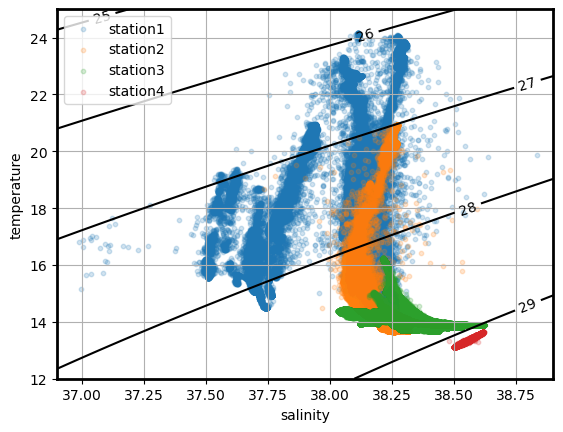

In [87]:
slim = (36.9,38.9)
tlim = (12,25)
fig, ax = pyn.seawater.plot_ts(slim, tlim)

#i = 1
for i in range(1,5):
    s = f"station{i}"
    ds = ctd[s]
    if i==1:
        ds = ds.sel(time=slice(None,"2023/11/01"))
    elif i==2:
        ds = ds.sel(time=slice(None,"2024/01/01"))
    pt = gsw.pt_from_CT(ds["SA"], ds["CT"]) # .2 degC difference with in situ temperature at depth
    ax.scatter(ds["salinity"], pt, s=10, alpha=0.2, marker="o", label=s)

ax.legend(loc="upper left")
ax.set_xlim(slim)
ax.set_ylim(tlim)

## using pynsitu: rotary spectrum

In [ ]:
df = ds.to_dataframe().drop(columns=["computer_time", "instrument_time", "instrument_delta_time"]).ts.resample_uniform("10min").fillna(0.)

In [ ]:
(df.index - df.index[0])/pd.Timedelta("1d") 

In [ ]:
omega = 2*2*np.pi
df["v1_syn"] = 0.1*np.cos( (df.index-df.index[0])/pd.Timedelta("1d") *omega)
df["v2_syn"] = 0.1*np.cos( (df.index-df.index[0])/pd.Timedelta("1d") *omega)

In [ ]:
E = df.ts.spectrum(nperseg=24 * 6 * 15, complex=("v1", "v2"), unit="1d")
Esyn = df.ts.spectrum(nperseg=24 * 6 * 15, complex=("v1_syn", "v2_syn"), unit="1d")

In [ ]:
fig, ax = plt.subplots(1,1)
E["v1_v2"].plot()
#Esyn["v1_syn_v2_syn"].plot()
ax.set_yscale("log")
ax.set_xlim(-12,12)
ax.grid()
#ax.axvline(-2)
ax.axvline(24/17, color="k", ls="-")
ax.axvline(-24/17, color="k", ls="-")
ax.axvline(1, color="k", ls="--")
ax.axvline(2, color="k", ls="--")
#ax.set_ylim(1e-8, 1e1)